# Peptide Retention Time Prediction using Encoder-Only Transformer – Evaluation & Test Notebook

This notebook loads a trained Encoder-Only Transformer model and evaluates it on validation/test data, and shows how to predict RT for new peptide sequences.

---

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('./src')

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTEncoderModel, split_dataset, collate, compute_metrics

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import numpy as np

## 2. Configuration
Set data and saved model paths and model hyperparameters (must match training!).

In [ ]:
DATA_PATH = "data/cysty.txt"
MODEL_PATH = "models/cysty.pt"
D_MODEL = 160
N_HEADS = 8
N_LAYERS = 3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


## 3. Load Data and Model

In [11]:
# Tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)
print(f"Dataset size: {len(dataset)} samples")

# Use the same split as in training
_, val_ds = split_dataset(dataset, val_ratio=0.05, seed=42)
coll = lambda b: collate(b, tokenizer.pad_id)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, collate_fn=coll)

# Model
model = PeptideRTEncoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS
)

#if torch.cuda.is_available():
#    model = nn.DataParallel(model)

model=model.to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Dataset size: 11041 samples
Model size: 958242 parameters


## 4. Evaluate on Validation Set

In [4]:
# Get predictions and targets
all_preds, all_targets, all_peptides = [], [], []

with torch.no_grad():
    model.eval()
    for batch in val_loader:
        seqs, mask, rts = batch
        seqs, mask = seqs.to(DEVICE), mask.to(DEVICE)
        preds = model(seqs, mask).cpu().numpy()

        all_preds.append(preds)
        all_targets.append(rts.numpy())

        # Decode each sequence in the batch
        # seqs is a tensor of shape (batch_size, seq_len)
        decoded_batch = [dataset.tok.decode(seq.cpu().tolist()) for seq in seqs]
        all_peptides.extend(decoded_batch)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

c:\Users\mmakaranka\AppData\Local\pypoetry\Cache\virtualenvs\peptide-rt-transformer-KivCupBj-py3.12\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Compute main metrics.

In [5]:
# Convert numpy arrays to torch tensors
all_preds_torch = torch.tensor(all_preds)
all_targets_torch = torch.tensor(all_targets)

metrics = compute_metrics(all_preds_torch, all_targets_torch)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:26s}: {v:.5f}")


Validation metrics for model:
MAE                       : 0.02649
MSE                       : 0.00211
RMSE                      : 0.04589
Max_Abs_Error             : 0.62917
Median_Abs_Error          : 0.01872
Mean_Abs_Percentage_Error : 0.11725
Std_Error                 : 0.04556
Std_True                  : 0.21053
Std_Pred                  : 0.20816
R2                        : 0.95239
Explained_Variance        : 0.95317
Pearson                   : 0.97638
Spearman                  : 0.97869


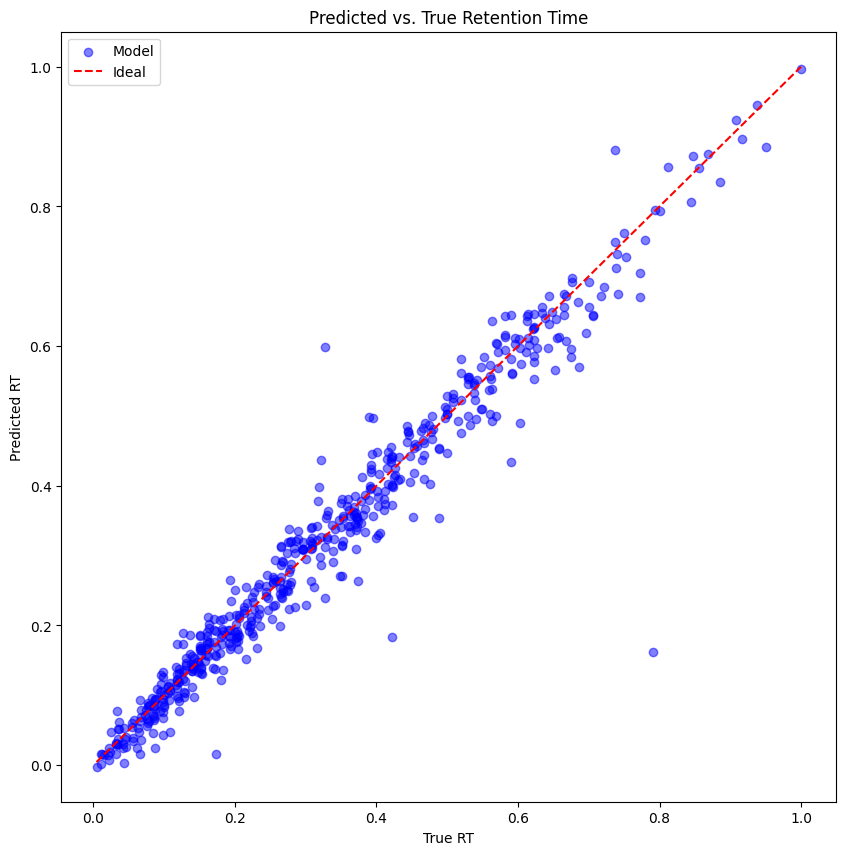

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(all_targets, all_preds, alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

## 5. Predict RT for New Peptide Sequences
Trained model usage is shown below.

In [10]:
def predict_peptide_rt(peptide_seq, model, tokenizer, device):
    """
    Predict RT for a single peptide sequence (no padding, mask omitted).
    """
    model.eval()
    seq_tensor = tokenizer.encode(peptide_seq).unsqueeze(0).to(device)
    mask = torch.zeros_like(seq_tensor, dtype=torch.bool)  # all False
    with torch.no_grad():
        pred = model(seq_tensor, mask)
    return float(pred.item())

def predict_peptide_batch_rt(peptide_seqs, model, tokenizer, device):
    """
    Predict RTs for a batch of peptide sequences.
    Returns a list of floats.
    """
    model.eval()
    # Encode all sequences (list of tensors of different lengths)
    seqs = [tokenizer.encode(seq) for seq in peptide_seqs]
    # Pad to same length: (batch, max_len)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=tokenizer.pad_id)
    # Mask: True where <pad>
    key_padding_mask = seqs_padded.eq(tokenizer.pad_id)
    seqs_padded, key_padding_mask = seqs_padded.to(device), key_padding_mask.to(device)
    with torch.no_grad():
        preds = model(seqs_padded, key_padding_mask)  # (batch,)
    return preds.cpu().tolist()

# Read all peptides and real RTs from the file
data = []
with open(DATA_PATH, 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # Skip empty lines
            peptide, rt = line.split('\t')
            data.append((peptide, float(rt)))

comparison_data = data[1000:1022]
peptides = [item[0] for item in comparison_data]
real_rts = [item[1] for item in comparison_data]

# ---- Single prediction ----
single_preds = []
for pep in peptides:
    rt_pred = predict_peptide_rt(pep, model, tokenizer, DEVICE)
    single_preds.append(dataset.unnormalize(rt_pred))

# ---- Batch prediction ----
batch_preds = predict_peptide_batch_rt(peptides, model, tokenizer, DEVICE)

# ---- Print comparison table ----
print("\nComparison of Real and Predicted Retention Times:")
print("-" * 85)
print(f"{'Peptide':40}  {'Real RT':>10}  {'Single Pred':>12}  {'Batch Pred':>12}")
print("-" * 85)
for pep, real, single, batch in zip(peptides, real_rts, single_preds, batch_preds):
    print(f"{pep:40}  {real:10.4f}  {single:12.4f}  {dataset.unnormalize(batch):12.4f}")

# Optional: Print how many peptides were read in total
print(f"\nTotal peptides in file: {len(data)}")


Comparison of Real and Predicted Retention Times:
-------------------------------------------------------------------------------------
Peptide                                      Real RT   Single Pred    Batch Pred
-------------------------------------------------------------------------------------
TIAQGGVLPNIQA                                 0.4620        0.4436        0.4436
VLLPKKTESHH                                   0.0820        0.0847        0.0847
AAVLEYLTAEIL                                  0.8680        0.8810        0.8810
LLPKKTESHHK                                   0.0700        0.0578        0.0578
AGLQFPVGRVHR                                  0.2430        0.2476        0.2476
NDEELNKLLGKV                                  0.4340        0.4598        0.4598
SSRAGLQFPVGRV                                 0.3370        0.3478        0.3478
ILELAGNAARDNK                                 0.1850        0.1766        0.1766
LLPKKTESHHKA                                  0.